In [49]:
library(tidycensus)
library(tidyverse)
library(sf)
library(ggmap)
library(viridis)
library(tigris)
library(leaflet)
options(tigris_use_cache = TRUE)

library(htmltools)
library(htmlwidgets)

# Load Worcester Census Data

In [4]:
wo_tract_df <- get_acs(
    state = "MA",
    county = "Worcester County",
    geography = "tract",
    variables =
        # "S2504_C02_030"
        c(percent_no_car="S2504_C02_027",
          percent_one_car="S2504_C02_028",
          percent_two_cars="S2504_C02_029",
          percent_three_cars="S2504_C02_030")
        ,
    geometry = TRUE
)

Getting data from the 2018-2022 5-year ACS

Using the ACS Subject Tables



In [5]:
# Aggregate in avg. number of cars per tract

wo_grouped_tract_df <- wo_tract_df %>%
    mutate(
        num_cars = as.numeric(case_when(
            variable=="percent_no_car" ~ "0",
            variable=="percent_one_car" ~ "1",
            variable=="percent_two_cars" ~ "2",
            variable=="percent_three_cars" ~ "3"
        ))
    ) %>%
    group_by(GEOID,NAME) %>%
    summarise(avg_num_cars = sum(num_cars * estimate/100)) %>%
    sf::st_transform('+proj=longlat +datum=WGS84')

head(wo_grouped_tract_df)

`summarise()` has grouped output by 'GEOID'. You can override using the
`.groups` argument.
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



GEOID       NAME                                                 
1 25027700100 Census Tract 7001; Worcester County; Massachusetts   
2 25027701101 Census Tract 7011.01; Worcester County; Massachusetts
3 25027701102 Census Tract 7011.02; Worcester County; Massachusetts
4 25027702201 Census Tract 7022.01; Worcester County; Massachusetts
5 25027702202 Census Tract 7022.02; Worcester County; Massachusetts
6 25027703100 Census Tract 7031; Worcester County; Massachusetts   
  avg_num_cars geometry                      
1 2.068        POLYGON ((-71.98611 42.6277...
2 1.986        POLYGON ((-72.08083 42.6384...
3 1.613        POLYGON ((-72.06762 42.6761...
4 2.110        POLYGON ((-72.27196 42.6746...
5 1.766        POLYGON ((-72.11663 42.6266...
6 1.578        POLYGON ((-72.27666 42.5704...

# Load WRTA Lines

In [6]:
wrta_folder = "rta-gtfs-files/unzipped-files/wrta-ma-us"
wrta_lines_df = read_csv(file.path(wrta_folder,"shapes.txt"))

wrta_routes_df <- read_csv(file.path(wrta_folder,"routes.txt"))

wrta_trips_df <- read_csv(file.path(wrta_folder,"trips.txt"))

Rows: 100363 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): shape_id
dbl (4): shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): route_id, route_short_name, route_long_name, route_url, route_color...
dbl (3): agency_id, route_type, route_sort_order
lgl (1): route_desc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3227 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): trip_headsign, shape_id
dbl (7): trip_id, route_id, service_id, direction_id, bloc

In [25]:
head(wrta_lines_df)

shape_id shape_pt_lat shape_pt_lon shape_pt_sequence shape_dist_traveled
1 shp-1-03 42.23400     -71.79041    1                  0.00              
2 shp-1-03 42.23404     -71.79036    2                  0.01              
3 shp-1-03 42.23394     -71.79022    3                 16.03              
4 shp-1-03 42.23385     -71.79011    4                 29.53              
5 shp-1-03 42.23378     -71.79002    5                 40.28              
6 shp-1-03 42.23371     -71.78993    6                 51.03

In [34]:
# Get one shape for each route

# Get the distance per shape
shape_dist <- wrta_lines_df %>%
    group_by(shape_id) %>%
    summarise(max_dist = max(shape_dist_traveled))

# Select the longest shapes per route
distinct_route_shape_id <- wrta_trips_df %>%
    distinct(route_id, trip_headsign, direction_id, shape_id) %>%
    inner_join(shape_dist, by=join_by(shape_id)) %>%
    group_by(route_id, direction_id) %>%
    mutate(rank=rank(-max_dist)) %>%
    filter(rank==1) %>%
    as_tibble()

# Get the shapes for each `shape_id`
distinct_route_shapes <- distinct_route_shape_id %>%
    dplyr::select(route_id, shape_id, trip_headsign) %>%
    inner_join(wrta_lines_df, by=join_by(shape_id)) %>%
    mutate(across(route_id, as.character)) %>%
    inner_join(wrta_routes_df[,c("route_id","route_color")], by=join_by(route_id))

# Get distinct shape ids and colors
shape_id_colors <- distinct_route_shapes %>%
    dplyr::select(shape_id, route_color) %>%
    distinct()

head(distinct_route_shapes)

route_id shape_id trip_headsign                     shape_pt_lat shape_pt_lon
1 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23400     -71.79041   
2 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23404     -71.79036   
3 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23394     -71.79022   
4 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23385     -71.79011   
5 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23378     -71.79002   
6 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23371     -71.78993   
  shape_pt_sequence shape_dist_traveled route_color
1 1                  0.00               6c64c4     
2 2                  0.01               6c64c4     
3 3                 16.03               6c64c4     
4 4                 29.53               6c64c4     
5 5                 40.28               6c64c4     
6 6                 51.03               6c64c4

# Plot

## Just Census data

In [10]:
# Create data -> color mapping function
pal <- colorNumeric(
  palette = "magma",
  domain = wo_grouped_tract_df$avg_num_cars[!is.na(wo_grouped_tract_df$avg_num_cars)]
)

In [11]:
# Create label
wo_grouped_tract_df$label <- paste0(
    "<b>Census Tract: </b>", gsub("Census Tract ","",wo_grouped_tract_df$NAME)," <br>",
    "<b>Avg. Number of Cars: </b>",wo_grouped_tract_df$avg_num_cars
)

wo_grouped_tract_df$label <- lapply(wo_grouped_tract_df$label, htmltools::HTML)

In [12]:
leaflet() %>%
  addProviderTiles(provider = "CartoDB.Positron") %>%
  addPolygons(
      data = wo_grouped_tract_df,
      color = ~pal(avg_num_cars),
      weight = 0.5,
      smoothFactor = 0.2,
      fillOpacity = 0.5,
      label = ~label
  ) %>%
  addLegend(
    position = "bottomright",
    pal = pal,
    values = wo_grouped_tract_df$avg_num_cars,
    title = "Avg. # Cars <br> per Household"
  )

HTML widgets cannot be represented in plain text (need html)

## Census + Single Test Route

In [13]:
test_route = distinct_route_shapes[distinct_route_shapes$route_id==1,]
head(test_route)

route_id shape_id trip_headsign                     shape_pt_lat shape_pt_lon
1 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23400     -71.79041   
2 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23404     -71.79036   
3 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23394     -71.79022   
4 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23385     -71.79011   
5 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23378     -71.79002   
6 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23371     -71.78993   
  shape_pt_sequence shape_dist_traveled route_color
1 1                  0.00               6c64c4     
2 2                  0.01               6c64c4     
3 3                 16.03               6c64c4     
4 4                 29.53               6c64c4     
5 5                 40.28               6c64c4     
6 6                 51.03               6c64c4

`summarise()` has grouped output by 'trip_headsign', 'shape_id'. You can
override using the `.groups` argument.


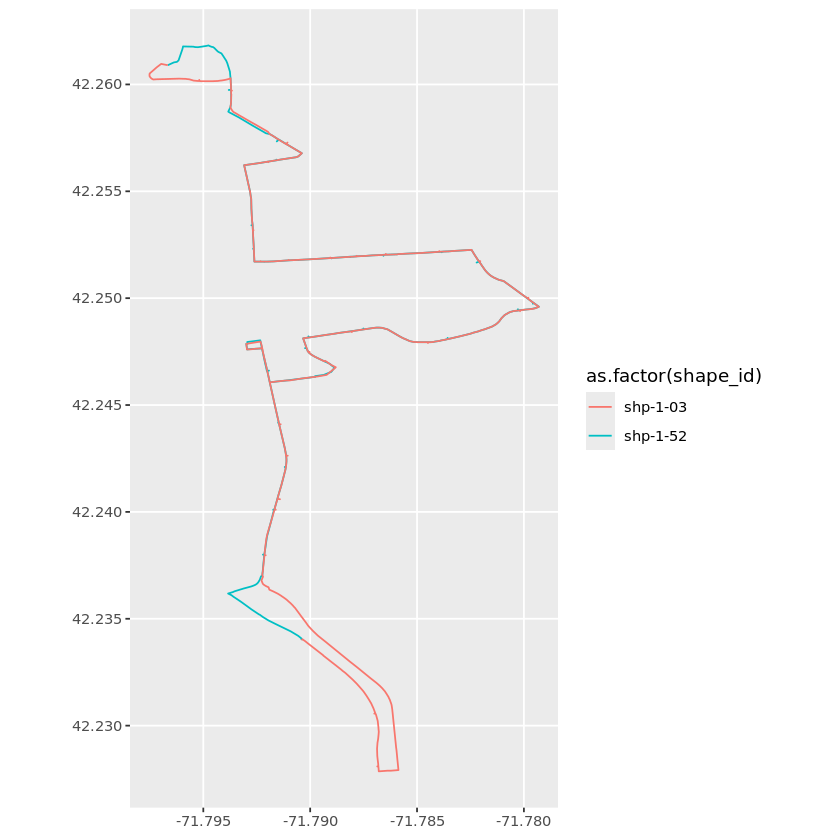

In [37]:
new_lines <- test_route %>%
  st_as_sf(coords = c("shape_pt_lon", "shape_pt_lat")) %>%
  group_by(trip_headsign,shape_id,route_color) %>%
  dplyr::summarize(do_union=FALSE) %>%  # do_union=FALSE doesn't work as well
  st_cast("LINESTRING")
# %>%
#   sf::sf_transform('+proj=longlat +datum=WGS84')

ggplot() + geom_sf(data=new_lines, aes(color=as.factor(shape_id)))

In [38]:
new_lines

trip_headsign                     shape_id route_color
1 ROUTE 146 + WALMART               shp-1-52 6c64c4     
2 ROUTE 146 + WALMART >> HUB CENTER shp-1-03 6c64c4     
  geometry                      
1 LINESTRING (-71.79666 42.26...
2 LINESTRING (-71.79041 42.23...

In [40]:
leaflet() %>%
  addProviderTiles(provider = "CartoDB.Positron") %>%
  addPolygons(
      data = wo_grouped_tract_df,
      color = ~pal(avg_num_cars),
      weight = 0.5,
      smoothFactor = 0.2,
      fillOpacity = 0.5,
      label = ~label
  ) %>%
  addPolylines(
      data=new_lines,
      weight=4,
      label=~paste0("WRTA: ",trip_headsign)
      
  ) 
# %>%
#   addLegend(
#     position = "bottomright",
#     pal = pal,
#     values = wo_grouped_tract_df$avg_num_cars,
#     title = "Avg. # Cars <br> per Household"
#   )

HTML widgets cannot be represented in plain text (need html)

## Census + All Routes

`summarise()` has grouped output by 'trip_headsign', 'shape_id'. You can
override using the `.groups` argument.


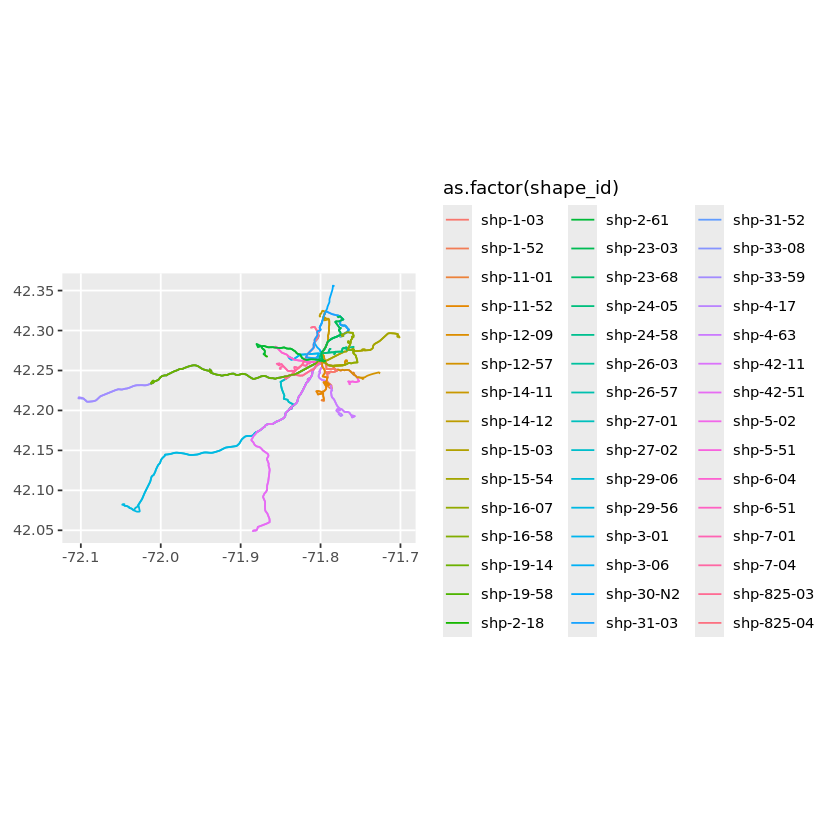

In [19]:
all_route_lines <- distinct_route_shapes %>%
  st_as_sf(coords = c("shape_pt_lon", "shape_pt_lat")) %>%
  group_by(trip_headsign,shape_id,route_color) %>%
  dplyr::summarize(do_union=FALSE) %>%  # do_union=FALSE doesn't work as well
  st_cast("LINESTRING")
# %>%
#   sf::sf_transform('+proj=longlat +datum=WGS84')

ggplot() + geom_sf(data=all_route_lines, aes(color=as.factor(shape_id)))

In [22]:
map <- leaflet() %>%
  addProviderTiles(provider = "CartoDB.Positron") %>%
  addPolygons(
      data = wo_grouped_tract_df,
      color = ~pal(avg_num_cars),
      weight = 0.5,
      smoothFactor = 0.2,
      fillOpacity = 0.5,
      label = ~label
  ) %>%
  addPolylines(
      data=all_route_lines,
      weight=3,
      label=~paste0("WRTA: ",trip_headsign)
      
  ) %>%
  addLegend(
    position = "bottomright",
    pal = pal,
    values = wo_grouped_tract_df$avg_num_cars,
    title = "Avg. # Cars <br> per Household"
  )

map

HTML widgets cannot be represented in plain text (need html)

In [31]:
# Select the longest shapes per route
all_route_shape_id <- wrta_trips_df %>%
    distinct(route_id, trip_headsign, direction_id, shape_id) %>%
    inner_join(shape_dist, by=join_by(shape_id)) %>%
    as_tibble()

# Get the shapes for each `shape_id`
all_route_shape_id <- all_route_shape_id %>%
    dplyr::select(route_id, shape_id, trip_headsign) %>%
    inner_join(wrta_lines_df, by=join_by(shape_id)) %>%
    mutate(across(route_id, as.character)) %>%
    inner_join(wrta_routes_df[,c("route_id","route_color")], by=join_by(route_id))

head(all_route_shape_id)

route_id shape_id trip_headsign                     shape_pt_lat shape_pt_lon
1 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23400     -71.79041   
2 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23404     -71.79036   
3 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23394     -71.79022   
4 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23385     -71.79011   
5 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23378     -71.79002   
6 1        shp-1-03 ROUTE 146 + WALMART >> HUB CENTER 42.23371     -71.78993   
  shape_pt_sequence shape_dist_traveled route_color
1 1                  0.00               6c64c4     
2 2                  0.01               6c64c4     
3 3                 16.03               6c64c4     
4 4                 29.53               6c64c4     
5 5                 40.28               6c64c4     
6 6                 51.03               6c64c4

`summarise()` has grouped output by 'trip_headsign', 'shape_id'. You can
override using the `.groups` argument.


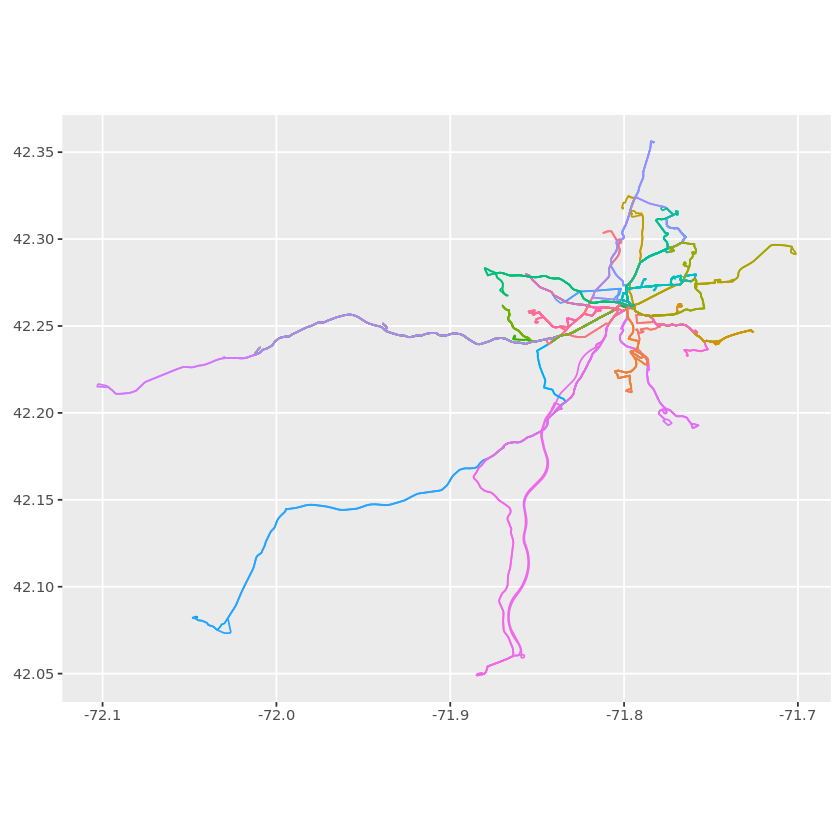

In [41]:
all_route_lines <- all_route_shape_id %>%
  st_as_sf(coords = c("shape_pt_lon", "shape_pt_lat")) %>%
  group_by(trip_headsign,shape_id,route_color) %>%
  dplyr::summarize(do_union=FALSE) %>%  # do_union=FALSE doesn't work as well
  st_cast("LINESTRING")
# %>%
#   sf::sf_transform('+proj=longlat +datum=WGS84')

ggplot() + geom_sf(data=all_route_lines, aes(color=as.factor(shape_id))) + theme(legend.position="none")

In [48]:
map <- leaflet() %>%
  addProviderTiles(provider = "CartoDB.Positron") %>%
  addPolygons(
      data = wo_grouped_tract_df,
      color = ~pal(avg_num_cars),
      weight = 0.5,
      smoothFactor = 0.2,
      fillOpacity = 0.5,
      label = ~label
  ) %>%
  addPolylines(
      data=all_route_lines,
      weight=3,
      label=~paste0("WRTA: ",trip_headsign)
      
  ) %>%
  addLegend(
    position = "bottomright",
    pal = pal,
    values = wo_grouped_tract_df$avg_num_cars,
    title = "Avg. # Cars <br> per Household"
  )

map

HTML widgets cannot be represented in plain text (need html)

In [45]:
saveWidget(map, file="wrta_interactive.html")